In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.
import tensorflow

In [19]:
from speedml import Speedml
sml = Speedml('input/train.csv', 
              'input/test.csv', 
              target = 'SalePrice',
              uid = 'Id')
sml.shape()

OSError: [WinError 126] The specified module could not be found

In [ ]:
sml.configure('overfit_threshold',  sml.np.sqrt(sml.train.shape[0]) / sml.train.shape[0])
sml.configure('outpath',  "/")
sml.configure('high_cardinality',  30)

In [ ]:
eda_result_df = sml.eda()
eda_result_df

In [ ]:
print(type(sml.train))
sml.train.head()

# Deal with Outliers 

 Rules of thunmbs here:
 
* Check the relationship b.t. the target (SalePrice) the outlier feature from the eda result
* For a specific feature, if there are extreme values along that feature (far different from the most data on that feature axis), we can check if it could potentially provide information gain. If yes, keep it; otherwise drop it.
* Information gain here: not entropy kind of stuff, but very simple check: How those seemingly outliers correlates to the target feature (SalePrice) ? Or can they help to narrow down or restrain the SalePrice's range ? 

>show the outlier columns, types, and r value w.r.t the SalePrice

In [ ]:
from scipy.stats import pearsonr 

In [ ]:
outliers_col = eda_result_df['Results'][1]
before_ol_remove_df = pd.DataFrame ({
            'col name': outliers_col, 
            'type': [sml.train[col].dtype for col in outliers_col],
            'r-val': [pearsonr(sml.train[col], sml.train['SalePrice'])[0] for col in outliers_col]
        })
before_ol_remove_df

In [ ]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)

### check **LotArea**

In [ ]:
sns.jointplot(x='LotArea', y="SalePrice", data=sml.train, kind="reg") 

if we look into for LotArea's seemingly outliers, say where LotArea > 52000

In [ ]:
temp_df = sml.train[sml.train['LotArea'] > 52000]
print('check outlier precentage = {:.3f} %'.format(temp_df.shape[0]/sml.train.shape[0]*100.0))
sns.jointplot(x='LotArea', y="SalePrice", data=temp_df, kind="reg")


LotArea seems to be highly relative to the SalePrice, (r=.26)
and those seemingly outliers are also relative to the SalePrice. (r = .14),

So if we treat those as outliers, we might somehow hide the data from the training model and hurt the predictions.

In the LotArea feature, different values in different range just show different linear relationship (from the perspective of linear reg.) to the SalePrice values. Having far away values does not always make it true outlier.

conclusion: ** keep the LotArea**

### check **BsmtFinSF2**

since *BsmtFinSF2: Type 2 finished square feet*
> 0 basically just mean no information. So we should analyze without 0 here to have clear picture of how it affects the SalePrice

In [ ]:
temp_df = sml.train[sml.train['BsmtFinSF2'] > 0]
print('check precentage = {:.3f} %'.format(temp_df.shape[0]/sml.train.shape[0]*100.0))
sns.jointplot(x='BsmtFinSF2', y="SalePrice", data=temp_df, kind="reg") 

BsmtFinSF2 without 0 now seems to be highly related to the SalePrice, (r=.2)

conclusion: ** keep the BsmtFinSF2**

### check **LowQualFinSF**

> same reason as BstmFinSF2, we have to focus on LowQualFinSF > 0

In [ ]:
temp_df = sml.train[sml.train['LowQualFinSF'] > 0]
print('check precentage = {:.3f} %'.format(temp_df.shape[0]/sml.train.shape[0]*100.0))
sns.jointplot(x='LowQualFinSF', y="SalePrice", data=temp_df, kind="reg") 

LowQualFinSF without 0 now seems to be highly related to the SalePrice, (r=.3)
There is one outlier, which compose 1/1460 ~= 0.0685 % of the data => upper = 99.93

conclusion: ** keep the LowQualFinSF but remove one outlier (~upper = 99.93)**

### check **BsmtHalfBath**

In [ ]:
temp_df = sml.train[sml.train['BsmtHalfBath'] > -1]
print('check precentage = {:.3f} %'.format(temp_df.shape[0]/sml.train.shape[0]*100.0))
sns.jointplot(x='BsmtHalfBath', y="SalePrice", data=temp_df, kind="reg") 

BsmtHalfBath = 2 seems to restrain the range of SalePrice, which could be still informative. 

conclusion: ** keep the BsmtHalfBath**

### check **KitchenAbvGr**

In [ ]:
sns.jointplot(x='KitchenAbvGr', y="SalePrice", data=sml.train, kind="reg") 

same reason as BsmtHalfBath

conclusion: ** keep the KitchenAbvGr**

### check **EnclosedPorch**

> same reason as BstmFinSF2, we have to focus on EnclosedPorch > 0

In [ ]:
sns.jointplot(x='EnclosedPorch', y="SalePrice", data=sml.train, kind="reg") 

In [ ]:
temp_df = sml.train[sml.train['EnclosedPorch'] > 0]
print('check precentage = {:.3f} %'.format(temp_df.shape[0]/sml.train.shape[0]*100.0))
sns.jointplot(x='EnclosedPorch', y="SalePrice", data=temp_df, kind="reg") 

Wow, the seemingly outlier almost follows the linear relationsip from the above.

conclusion: ** keep the EnclosedPorch**

### check **3SsnPorch**

In [ ]:
sns.jointplot(x='3SsnPorch', y="SalePrice", data=sml.train, kind="reg") 

focus on 3SsnPorch > 200

In [ ]:
temp_df = sml.train[sml.train['3SsnPorch'] > 200]
print('check precentage = {:.3f} %'.format(temp_df.shape[0]/sml.train.shape[0]*100.0))
sns.jointplot(x='3SsnPorch', y="SalePrice", data=temp_df, kind="reg") 

it seems that having too much 3SsnPorch area have a slightly negative effect on the SalePrice, hmm...

The outlier almost follows the linear relationsip from the above.

conclusion: ** keep the 3SsnPorch**

### check **ScreenPorch**

In [ ]:
sns.jointplot(x='ScreenPorch', y="SalePrice", data=sml.train, kind="reg") 

ok, nice then. seemingly outliers follow the positive relationship

conclusion: ** keep the 3SsnPorch**

### check **PoolArea**

In [ ]:
sns.jointplot(x='PoolArea', y="SalePrice", data=sml.train, kind="reg") 

focus on PoolArea > 400

In [ ]:
temp_df = sml.train[sml.train['PoolArea'] > 400]
print('check precentage = {:.3f} %'.format(temp_df.shape[0]/sml.train.shape[0]*100.0))
sns.jointplot(x='PoolArea', y="SalePrice", data=temp_df, kind="reg") 

the seemingly outliers seems to restrain the SalePrice to around 25000, if there are pools!

conclusion: ** keep the PoolArea**

### check **MiscVal**

In [ ]:
sns.jointplot(x='MiscVal', y="SalePrice", data=sml.train, kind="reg") 

ok, nice then. seemingly outliers follow the slightly negative relationship

conclusion: ** keep the MisVal**

Observe from the distribution above, we can assume whether there might be outliers or not

* LotArea: Lot size in square feet
* BsmtFinSF2: Type 2 finished square feet 
* LowQualFinSF: Low quality finished square feet (all floors)  
* BsmtHalfBath: Basement half bathrooms 
* KitchenAbvGr: Total rooms above grade (does not include bathrooms) 
* EnclosedPorch: Enclosed porch area in square feet
* 3SsnPorch: Three season porch area in square feet
* ScreenPorch: Screen porch area in square feet
* PoolArea: Pool area in square feet
* MiscVal: $Value of miscellaneous feature

this function removes the outliers (upper) and draw the continuous plot before and after the removal


In [ ]:
def plot_outliers(outlier_dict):
    for col in outlier_dict:
        sml.plot.continuous(col)
        sml.feature.outliers(col, upper=outlier_dict[col])
        sml.plot.continuous(col)

In [ ]:

outlier_dict = {
    'LowQualFinSF'  :  99.92,
}
'''
outlier_dict = {
    'LotArea'       :  99.5,
    'BsmtFinSF2'    :  99 ,   
    'LowQualFinSF'  :  99.93,
    'BsmtHalfBath'  :  99,
    'KitchenAbvGr'  :  99,
    'EnclosedPorch' :  99,
    '3SsnPorch'     :  99,
    'ScreenPorch'   :  99,
    'PoolArea'      :  99,
    'MiscVal'       :  99,
}
'''

plot_outliers(outlier_dict)


# Feature Engineering

In [ ]:
sml.feature.impute()
eda_result_df = sml.eda()
eda_result_df

In [ ]:
high_card_num_col = eda_result_df['Results'][4]
df = pd.DataFrame ({
            'col name': high_card_num_col, 
            'type': [sml.train[col].dtype for col in high_card_num_col],
            'r-val': [pearsonr(sml.train[col], sml.train['SalePrice'])[0] for col in high_card_num_col]
        })
df

## High cardinality num 

> create density features for all numerical cols with high card. num.

In [ ]:
'''
for col in high_card_num_col:
    if col != 'SalePrice':
        sml.feature.density(col)
'''    

In [ ]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 25

## Category text 

In [ ]:
text_cat_col = eda_result_df['Results'][6]
print(len(text_cat_col))
sml.train[text_cat_col].head(25)

> convert text with category type into numerical labels

In [ ]:
for col in text_cat_col:
    sml.feature.labels([col])

In [ ]:
sml.eda()

In [ ]:
sml.train.head(20)

In [ ]:
sns.distplot(sml.train['SalePrice'])

# Use DNN to train with multiple features

* Use Adam
* Xavier initialization
* Drop

In [2]:
#train = sml.train
#test = sml.test

train = pd.read_csv('input/processed_train.csv')
test = pd.read_csv('input/processed_test.csv')

print(train.head(3))
print(test.head(3))

   MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
0          60         3         65.0     8450       1      0         3   
1          20         3         80.0     9600       1      0         3   
2          60         3         68.0    11250       1      0         0   

   LandContour  Utilities  LotConfig    ...      PoolArea  PoolQC  Fence  \
0            3          0          4    ...             0       0      2   
1            3          0          2    ...             0       0      2   
2            3          0          4    ...             0       0      2   

   MiscFeature  MiscVal  MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0            2        0       2    2008         8              4     208500  
1            2        0       5    2007         8              4     181500  
2            2        0       9    2008         8              4     223500  

[3 rows x 80 columns]
   MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  L

In [3]:
train_x = train[[col for col in train.columns if col != 'SalePrice']]
train_y = np.log(train['SalePrice']).values.reshape(train_x.shape[0], 1)

train_length = int(len(train_x)*.9)
valid_x = train_x.iloc[train_length:,:]
valid_y = train_y[train_length:,:]

train_x = train_x.iloc[:train_length,:]
train_y = train_y[:train_length,:]

train_x = train_x.T
train_y = train_y.T
valid_x = valid_x.T
valid_y = valid_y.T

test_x = test.T

print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape, test_x.shape)

(79, 1314) (1, 1314) (79, 146) (1, 146) (79, 1459)


In [19]:
import math
from time import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(tf.float32, shape=(n_x, None), name='X')
    Y = tf.placeholder(tf.float32, shape=(n_y, None), name='Y')
    phase = tf.placeholder(tf.bool, name='phase')
    
    return X, Y, phase

def initialize_parameters( n_feature, n_output,
    layer_count = 3, hidden_neuron = [25, 12]):
       
    W = []
    b = []

    for i in range(layer_count):
        weight_str = 'W'+str(i+1)
        bias_str = 'b'+str(i+1)

        if i == 0:
            weight = tf.get_variable(weight_str, [hidden_neuron[i], n_feature], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
            bias = tf.get_variable(bias_str, [hidden_neuron[i], 1], initializer = tf.zeros_initializer())
        elif i == layer_count - 1:
            weight = tf.get_variable(weight_str, [n_output, hidden_neuron[i-1]], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
            bias = tf.get_variable(bias_str, [n_output, 1], initializer = tf.zeros_initializer())
        else:
            weight = tf.get_variable(weight_str, [hidden_neuron[i], hidden_neuron[i-1]], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
            bias = tf.get_variable(bias_str, [hidden_neuron[i], 1], initializer = tf.zeros_initializer())
            
        W.append(weight)
        b.append(bias)

    parameters = {
        'W': W,
        'b': b
    }

    return parameters

def batch_norm(x, n_out, phase_train):
    """
    Batch normalization on convolutional maps.
    Ref.: http://stackoverflow.com/questions/33949786/how-could-i-use-batch-normalization-in-tensorflow
    Args:
        x:           Tensor, 4D BHWD input maps
        n_out:       integer, depth of input maps
        phase_train: boolean tf.Varialbe, true indicates training phase
        scope:       string, variable scope
    Return:
        normed:      batch-normalized maps
    """
    with tf.variable_scope('bn'):
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                     name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                      name='gamma', trainable=True)
        batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
        ema = tf.train.ExponentialMovingAverage(decay=0.99)

        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(phase_train,
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed
    
def forward_propagation(X, parameters, is_training):

    W = parameters['W']
    b = parameters['b']
    
    for i in range(len(W)):
        weight = W[i]
        bias = b[i]
        scope = 'layer' + str(i+1)
        with tf.variable_scope(scope):
            if i == 0:
                output = tf.matmul(weight, X) + bias
                output = tf.transpose(output, name='transpose_to')
                output = batch_norm(output, output.get_shape()[1], is_training)
                output = tf.transpose(output, name='transpose_back')
                activation = tf.nn.relu(output)
            elif i == len(W)-1:
                output = tf.matmul(weight, activation) + bias
            else:
                output = tf.matmul(weight, activation) + bias
                output = tf.transpose(output, name='transpose_to')
                output = batch_norm(output, output.get_shape()[1], is_training)
                output = tf.transpose(output, name='transpose_back')
                activation = tf.nn.relu(output)

    return output

def compute_cost(parameters, output, Y):

    with tf.name_scope('loss'):
        loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(Y, output))))
        for w in parameters['W']:
            loss = loss + 0.01*tf.nn.l2_loss(w)
        
        return loss
        
    raise ValueError('Cannot enter scope \"loss \"')
    
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X.iloc[:, permutation]
    shuffled_Y = Y[:,permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X.iloc[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X.iloc[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches
    
def model(X_train, Y_train, 
        X_valid, Y_valid,
        X_test,
        learning_rate = 0.01,
        num_epochs = 1500, 
        minibatch_size = 32, 
        print_cost = True, 
        layer_count = 3, 
        hidden_neuron = [25, 12]):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    with tf.device("/gpu:0"):
        # Create Placeholders of shape (n_x, n_y)
        X, Y, phase = create_placeholders(n_x, n_y)

        # Initialize parameters
        # n_feature, n_output,
        # layer_count = 3, hidder_neuron = [25, 12]
        parameters = initialize_parameters(n_x, n_y, layer_count = layer_count, hidden_neuron = hidden_neuron)

        # Forward propagation: Build the forward propagation in the tensorflow graph
        output = forward_propagation(X, parameters, phase)

        # Cost function: Add cost function to tensorflow graph
        cost = compute_cost(parameters, output, Y)

        # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
        global_step = tf.Variable(0, trainable=False)
        online_learning_rate = tf.train.exponential_decay(learning_rate, global_step,
                                               20000, 0.95, staircase=True)

        # Note: when training, the moving_mean and moving_variance need to be updated. 
        # By default the update ops are placed in tf.GraphKeys.UPDATE_OPS, 
        # so they need to be added as a dependency to the train_op
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):                                       
            optimizer = tf.train.AdamOptimizer(learning_rate = online_learning_rate).minimize(cost, global_step=global_step)

        # Initialize all the variables
        init = tf.global_variables_initializer()

        # show graph
        show_graph(tf.get_default_graph().as_graph_def())

        # Calculate the correct predictions
        rmse = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(Y, output))))

        # Calculate accuracy on the test set
        rmse = tf.cast(rmse, "float")

        # add for time usage prediction
        start_time = 0
    
    config = tf.ConfigProto(allow_soft_placement = True)
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = 0.8
    
    # Start the session to compute the tensorflow graph
    with tf.Session(config=config) as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            if epoch == 0:
                start_time = time()
                
            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y, phase:True})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every 100 epoch
            if print_cost == True and (epoch+1) % 100 == 0:
                duration = int(time() - start_time)
                remain_epoch = num_epochs - epoch
                remain_epoch_round = int(remain_epoch/100)
                remain_time = remain_epoch_round*duration
                remain_hour = int(remain_time/3600)
                remain_minute = int((remain_time - remain_hour*3600) / 60)
                remain_second = int(remain_time - remain_hour*3600 - remain_minute*60)
                
                print ("=======================================")
                print ("Cost after %i epochs: %.5f" % (epoch+1, epoch_cost))
                print ("Trainning set rmse:", rmse.eval({X: X_train, Y: Y_train, phase:False}))
                print ("Validation set rmse:", rmse.eval({X: X_valid, Y: Y_valid, phase:False}))
                print ("Remaining time: %d:%d:%d \n" % (remain_hour, remain_minute, remain_second))
                start_time = time()
                
            if print_cost == True and epoch % 5 == 0 and epoch > 300:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        final_output = sess.run(output, feed_dict={X: X_test, phase: False})
        print(final_output.shape)
        submission = pd.DataFrame({
            "Id": np.arange(final_output.shape[1]),
            "SalePrice": np.exp(final_output.reshape((final_output.shape[1],)))
        })
        submission.to_csv("submission_lr_decay_slower.csv", encoding='utf-8', index=False)
        
        return parameters

Cost after 100 epochs: 0.49896
Trainning set rmse: 1.00258
Validation set rmse: 1.0384
Remaining time: 13:19:44 

Cost after 200 epochs: 0.31999
Trainning set rmse: 0.607662
Validation set rmse: 0.633816
Remaining time: 14:9:26 

Cost after 300 epochs: 0.27505
Trainning set rmse: 0.870788
Validation set rmse: 0.90477
Remaining time: 14:9:9 

Cost after 400 epochs: 0.24412
Trainning set rmse: 0.260893
Validation set rmse: 0.253892
Remaining time: 13:18:56 

Cost after 500 epochs: 0.23846
Trainning set rmse: 1.04468
Validation set rmse: 1.07289
Remaining time: 12:28:45 

Cost after 600 epochs: 0.25049
Trainning set rmse: 1.14026
Validation set rmse: 1.11603
Remaining time: 12:28:30 

Cost after 700 epochs: 0.28515
Trainning set rmse: 2.12602
Validation set rmse: 2.13973
Remaining time: 13:18:8 

Cost after 800 epochs: 0.21717
Trainning set rmse: 0.454792
Validation set rmse: 0.470916
Remaining time: 13:17:52 

Cost after 900 epochs: 0.24247
Trainning set rmse: 0.974957
Validation set rms

Cost after 5400 epochs: 0.22145
Trainning set rmse: 0.579567
Validation set rmse: 0.558073
Remaining time: 11:27:24 

Cost after 5500 epochs: 0.21275
Trainning set rmse: 0.532314
Validation set rmse: 0.524635
Remaining time: 11:27:10 

Cost after 5600 epochs: 0.20757
Trainning set rmse: 0.234525
Validation set rmse: 0.238339
Remaining time: 11:26:56 

Cost after 5700 epochs: 0.21055
Trainning set rmse: 0.965391
Validation set rmse: 0.948343
Remaining time: 11:26:42 

Cost after 5800 epochs: 0.20879
Trainning set rmse: 0.365614
Validation set rmse: 0.341304
Remaining time: 11:26:28 

Cost after 5900 epochs: 0.21604
Trainning set rmse: 0.406182
Validation set rmse: 0.38811
Remaining time: 11:26:14 

Cost after 6000 epochs: 0.21438
Trainning set rmse: 0.699218
Validation set rmse: 0.674675
Remaining time: 11:26:0 

Cost after 6100 epochs: 0.20157
Trainning set rmse: 0.801302
Validation set rmse: 0.828236
Remaining time: 11:25:46 

Cost after 6200 epochs: 0.21338
Trainning set rmse: 0.3517

Cost after 10600 epochs: 0.19530
Trainning set rmse: 1.03105
Validation set rmse: 1.05663
Remaining time: 11:15:16 

Cost after 10700 epochs: 0.20017
Trainning set rmse: 0.776652
Validation set rmse: 0.746978
Remaining time: 11:15:2 

Cost after 10800 epochs: 0.20920
Trainning set rmse: 0.610855
Validation set rmse: 0.584644
Remaining time: 11:14:48 

Cost after 10900 epochs: 0.20323
Trainning set rmse: 0.214561
Validation set rmse: 0.234472
Remaining time: 11:14:34 

Cost after 11000 epochs: 0.20610
Trainning set rmse: 0.276897
Validation set rmse: 0.273066
Remaining time: 11:14:20 

Cost after 11100 epochs: 0.19400
Trainning set rmse: 0.751734
Validation set rmse: 0.730323
Remaining time: 11:14:6 

Cost after 11200 epochs: 0.21834
Trainning set rmse: 1.06291
Validation set rmse: 1.036
Remaining time: 11:13:52 

Cost after 11300 epochs: 0.20933
Trainning set rmse: 0.832908
Validation set rmse: 0.806738
Remaining time: 11:13:38 

Cost after 11400 epochs: 0.20174
Trainning set rmse: 0.5

Cost after 15800 epochs: 0.19162
Trainning set rmse: 0.923449
Validation set rmse: 0.897398
Remaining time: 11:3:8 

Cost after 15900 epochs: 0.19504
Trainning set rmse: 0.861589
Validation set rmse: 0.841618
Remaining time: 11:2:54 

Cost after 16000 epochs: 0.19958
Trainning set rmse: 0.483622
Validation set rmse: 0.453827
Remaining time: 11:2:40 

Cost after 16100 epochs: 0.19068
Trainning set rmse: 0.305623
Validation set rmse: 0.33236
Remaining time: 11:2:26 

Cost after 16200 epochs: 0.19794
Trainning set rmse: 0.273467
Validation set rmse: 0.274526
Remaining time: 11:2:12 

Cost after 16300 epochs: 0.19941
Trainning set rmse: 0.311994
Validation set rmse: 0.293502
Remaining time: 11:1:58 

Cost after 16400 epochs: 0.19708
Trainning set rmse: 0.859351
Validation set rmse: 0.833744
Remaining time: 11:1:44 

Cost after 16500 epochs: 0.19071
Trainning set rmse: 0.329161
Validation set rmse: 0.321568
Remaining time: 11:1:30 

Cost after 16600 epochs: 0.19023
Trainning set rmse: 1.026

Cost after 21000 epochs: 0.20039
Trainning set rmse: 0.530932
Validation set rmse: 0.514611
Remaining time: 10:51:0 

Cost after 21100 epochs: 0.20020
Trainning set rmse: 0.951549
Validation set rmse: 0.930594
Remaining time: 10:50:46 

Cost after 21200 epochs: 0.18325
Trainning set rmse: 0.73696
Validation set rmse: 0.714736
Remaining time: 10:50:32 

Cost after 21300 epochs: 0.20476
Trainning set rmse: 0.568223
Validation set rmse: 0.543924
Remaining time: 10:50:18 

Cost after 21400 epochs: 0.18767
Trainning set rmse: 0.80252
Validation set rmse: 0.778543
Remaining time: 10:50:4 

Cost after 21500 epochs: 0.19122
Trainning set rmse: 0.797476
Validation set rmse: 0.775773
Remaining time: 10:49:50 

Cost after 21600 epochs: 0.19130
Trainning set rmse: 0.353341
Validation set rmse: 0.344589
Remaining time: 10:49:36 

Cost after 21700 epochs: 0.19244
Trainning set rmse: 0.371536
Validation set rmse: 0.373842
Remaining time: 10:49:22 

Cost after 21800 epochs: 0.19551
Trainning set rmse:

Cost after 26200 epochs: 0.19210
Trainning set rmse: 0.319149
Validation set rmse: 0.333568
Remaining time: 11:24:30 

Cost after 26300 epochs: 0.19278
Trainning set rmse: 0.338383
Validation set rmse: 0.359184
Remaining time: 11:24:15 

Cost after 26400 epochs: 0.19550
Trainning set rmse: 0.644115
Validation set rmse: 0.675384
Remaining time: 11:24:0 

Cost after 26500 epochs: 0.19391
Trainning set rmse: 0.719313
Validation set rmse: 0.692646
Remaining time: 11:23:45 

Cost after 26600 epochs: 0.19222
Trainning set rmse: 0.895623
Validation set rmse: 0.873373
Remaining time: 11:23:30 

Cost after 26700 epochs: 0.19169
Trainning set rmse: 0.329966
Validation set rmse: 0.32458
Remaining time: 12:8:48 

Cost after 26800 epochs: 0.19357
Trainning set rmse: 0.56646
Validation set rmse: 0.591988
Remaining time: 12:8:32 

Cost after 26900 epochs: 0.19680
Trainning set rmse: 0.436964
Validation set rmse: 0.422166
Remaining time: 12:8:16 

Cost after 27000 epochs: 0.20257
Trainning set rmse: 0

Cost after 31400 epochs: 0.18927
Trainning set rmse: 0.670582
Validation set rmse: 0.651981
Remaining time: 11:11:30 

Cost after 31500 epochs: 0.18199
Trainning set rmse: 0.806942
Validation set rmse: 0.781407
Remaining time: 11:56:0 

Cost after 31600 epochs: 0.18887
Trainning set rmse: 0.918374
Validation set rmse: 0.902106
Remaining time: 11:11:0 

Cost after 31700 epochs: 0.20643
Trainning set rmse: 0.56895
Validation set rmse: 0.599104
Remaining time: 11:10:45 

Cost after 31800 epochs: 0.19428
Trainning set rmse: 0.284847
Validation set rmse: 0.271774
Remaining time: 11:10:30 

Cost after 31900 epochs: 0.19866
Trainning set rmse: 0.499921
Validation set rmse: 0.517471
Remaining time: 11:10:15 

Cost after 32000 epochs: 0.18447
Trainning set rmse: 0.267782
Validation set rmse: 0.266653
Remaining time: 11:10:0 

Cost after 32100 epochs: 0.19221
Trainning set rmse: 0.39889
Validation set rmse: 0.423531
Remaining time: 11:9:45 

Cost after 32200 epochs: 0.19929
Trainning set rmse: 0

Cost after 36700 epochs: 0.18988
Trainning set rmse: 0.216951
Validation set rmse: 0.211121
Remaining time: 10:58:15 

Cost after 36800 epochs: 0.19610
Trainning set rmse: 0.645979
Validation set rmse: 0.618561
Remaining time: 10:58:0 

Cost after 36900 epochs: 0.19865
Trainning set rmse: 0.236838
Validation set rmse: 0.237826
Remaining time: 10:57:45 

Cost after 37000 epochs: 0.19252
Trainning set rmse: 0.568775
Validation set rmse: 0.545595
Remaining time: 10:57:30 

Cost after 37100 epochs: 0.17980
Trainning set rmse: 0.533166
Validation set rmse: 0.516022
Remaining time: 10:57:15 

Cost after 37200 epochs: 0.18333
Trainning set rmse: 0.40536
Validation set rmse: 0.392959
Remaining time: 10:57:0 

Cost after 37300 epochs: 0.19082
Trainning set rmse: 0.817104
Validation set rmse: 0.794453
Remaining time: 10:56:45 

Cost after 37400 epochs: 0.18161
Trainning set rmse: 0.431186
Validation set rmse: 0.406963
Remaining time: 10:56:30 

Cost after 37500 epochs: 0.18394
Trainning set rmse

Cost after 41900 epochs: 0.18422
Trainning set rmse: 1.04718
Validation set rmse: 1.07307
Remaining time: 10:45:15 

Cost after 42000 epochs: 0.19065
Trainning set rmse: 0.309529
Validation set rmse: 0.316787
Remaining time: 10:45:0 

Cost after 42100 epochs: 0.18041
Trainning set rmse: 0.559759
Validation set rmse: 0.589509
Remaining time: 10:44:45 

Cost after 42200 epochs: 0.18491
Trainning set rmse: 0.89021
Validation set rmse: 0.870309
Remaining time: 10:44:30 

Cost after 42300 epochs: 0.18573
Trainning set rmse: 0.213438
Validation set rmse: 0.199091
Remaining time: 10:44:15 

Cost after 42400 epochs: 0.19040
Trainning set rmse: 0.324643
Validation set rmse: 0.319396
Remaining time: 10:44:0 

Cost after 42500 epochs: 0.18552
Trainning set rmse: 0.433323
Validation set rmse: 0.407466
Remaining time: 10:43:45 

Cost after 42600 epochs: 0.18668
Trainning set rmse: 1.09451
Validation set rmse: 1.12249
Remaining time: 10:43:30 

Cost after 42700 epochs: 0.18015
Trainning set rmse: 0.

Cost after 47100 epochs: 0.18904
Trainning set rmse: 1.05103
Validation set rmse: 1.03073
Remaining time: 11:56:33 

Cost after 47200 epochs: 0.18673
Trainning set rmse: 0.357897
Validation set rmse: 0.350883
Remaining time: 11:14:8 

Cost after 47300 epochs: 0.17919
Trainning set rmse: 0.678304
Validation set rmse: 0.658682
Remaining time: 11:55:59 

Cost after 47400 epochs: 0.20043
Trainning set rmse: 0.629621
Validation set rmse: 0.603196
Remaining time: 11:13:36 

Cost after 47500 epochs: 0.18821
Trainning set rmse: 0.583286
Validation set rmse: 0.579866
Remaining time: 12:37:30 

Cost after 47600 epochs: 0.18789
Trainning set rmse: 1.09061
Validation set rmse: 1.08358
Remaining time: 11:55:8 

Cost after 47700 epochs: 0.18612
Trainning set rmse: 0.627706
Validation set rmse: 0.6382
Remaining time: 11:12:48 

Cost after 47800 epochs: 0.17934
Trainning set rmse: 1.04925
Validation set rmse: 1.04876
Remaining time: 11:54:34 

Cost after 47900 epochs: 0.17901
Trainning set rmse: 1.057

Cost after 52400 epochs: 0.18648
Trainning set rmse: 1.0085
Validation set rmse: 1.03276
Remaining time: 7:33:56 

Cost after 52500 epochs: 0.18169
Trainning set rmse: 0.694636
Validation set rmse: 0.704691
Remaining time: 7:33:45 

Cost after 52600 epochs: 0.16991
Trainning set rmse: 0.735859
Validation set rmse: 0.717517
Remaining time: 7:33:34 

Cost after 52700 epochs: 0.17581
Trainning set rmse: 0.888654
Validation set rmse: 0.867453
Remaining time: 7:33:23 

Cost after 52800 epochs: 0.17619
Trainning set rmse: 1.03953
Validation set rmse: 1.02389
Remaining time: 7:33:12 

Cost after 52900 epochs: 0.18836
Trainning set rmse: 0.899796
Validation set rmse: 0.890926
Remaining time: 7:33:1 

Cost after 53000 epochs: 0.17096
Trainning set rmse: 0.570296
Validation set rmse: 0.568322
Remaining time: 7:32:50 

Cost after 53100 epochs: 0.16441
Trainning set rmse: 0.320872
Validation set rmse: 0.314547
Remaining time: 8:13:48 

Cost after 53200 epochs: 0.18153
Trainning set rmse: 0.401681


Cost after 57700 epochs: 0.17215
Trainning set rmse: 0.592357
Validation set rmse: 0.621135
Remaining time: 7:24:13 

Cost after 57800 epochs: 0.17581
Trainning set rmse: 0.580355
Validation set rmse: 0.567613
Remaining time: 7:24:2 

Cost after 57900 epochs: 0.17809
Trainning set rmse: 0.855635
Validation set rmse: 0.882931
Remaining time: 7:23:51 

Cost after 58000 epochs: 0.17313
Trainning set rmse: 0.414085
Validation set rmse: 0.396328
Remaining time: 7:23:40 

Cost after 58100 epochs: 0.16616
Trainning set rmse: 0.967888
Validation set rmse: 0.9515
Remaining time: 7:23:29 

Cost after 58200 epochs: 0.17407
Trainning set rmse: 0.734665
Validation set rmse: 0.715076
Remaining time: 7:23:18 

Cost after 58300 epochs: 0.17826
Trainning set rmse: 0.481339
Validation set rmse: 0.462444
Remaining time: 7:23:7 

Cost after 58400 epochs: 0.17123
Trainning set rmse: 0.586076
Validation set rmse: 0.570469
Remaining time: 7:22:56 

Cost after 58500 epochs: 0.18437
Trainning set rmse: 0.88458

Cost after 63000 epochs: 0.17573
Trainning set rmse: 0.711782
Validation set rmse: 0.692163
Remaining time: 7:14:30 

Cost after 63100 epochs: 0.17286
Trainning set rmse: 1.06611
Validation set rmse: 1.04028
Remaining time: 7:14:19 

Cost after 63200 epochs: 0.18210
Trainning set rmse: 1.03134
Validation set rmse: 1.01411
Remaining time: 7:14:8 

Cost after 63300 epochs: 0.17743
Trainning set rmse: 0.831222
Validation set rmse: 0.826742
Remaining time: 7:13:57 

Cost after 63400 epochs: 0.16897
Trainning set rmse: 0.766612
Validation set rmse: 0.747124
Remaining time: 7:13:46 

Cost after 63500 epochs: 0.17585
Trainning set rmse: 0.544753
Validation set rmse: 0.539608
Remaining time: 7:13:35 

Cost after 63600 epochs: 0.17308
Trainning set rmse: 0.881061
Validation set rmse: 0.8588
Remaining time: 7:13:24 

Cost after 63700 epochs: 0.17178
Trainning set rmse: 0.425975
Validation set rmse: 0.451883
Remaining time: 7:13:13 

Cost after 63800 epochs: 0.16774
Trainning set rmse: 0.783123
V

Cost after 68300 epochs: 0.17117
Trainning set rmse: 0.88701
Validation set rmse: 0.861603
Remaining time: 7:4:47 

Cost after 68400 epochs: 0.15530
Trainning set rmse: 0.720411
Validation set rmse: 0.706377
Remaining time: 7:4:36 

Cost after 68500 epochs: 0.15363
Trainning set rmse: 1.123
Validation set rmse: 1.10199
Remaining time: 7:4:25 

Cost after 68600 epochs: 0.16477
Trainning set rmse: 0.504556
Validation set rmse: 0.489092
Remaining time: 7:4:14 

Cost after 68700 epochs: 0.17845
Trainning set rmse: 0.483046
Validation set rmse: 0.510486
Remaining time: 7:4:3 

Cost after 68800 epochs: 0.16472
Trainning set rmse: 0.954722
Validation set rmse: 0.932279
Remaining time: 7:3:52 

Cost after 68900 epochs: 0.16953
Trainning set rmse: 0.523932
Validation set rmse: 0.558698
Remaining time: 7:3:41 

Cost after 69000 epochs: 0.16395
Trainning set rmse: 0.591946
Validation set rmse: 0.621273
Remaining time: 7:3:30 

Cost after 69100 epochs: 0.16257
Trainning set rmse: 0.889351
Validati

Cost after 73600 epochs: 0.15383
Trainning set rmse: 0.738523
Validation set rmse: 0.715307
Remaining time: 7:32:48 

Cost after 73700 epochs: 0.18240
Trainning set rmse: 0.82821
Validation set rmse: 0.805466
Remaining time: 6:54:53 

Cost after 73800 epochs: 0.16548
Trainning set rmse: 0.707721
Validation set rmse: 0.687138
Remaining time: 6:54:42 

Cost after 73900 epochs: 0.16894
Trainning set rmse: 0.648342
Validation set rmse: 0.663758
Remaining time: 6:54:31 

Cost after 74000 epochs: 0.16755
Trainning set rmse: 0.906767
Validation set rmse: 0.885155
Remaining time: 6:54:20 

Cost after 74100 epochs: 0.16240
Trainning set rmse: 0.895746
Validation set rmse: 0.922176
Remaining time: 6:54:9 

Cost after 74200 epochs: 0.16380
Trainning set rmse: 0.391183
Validation set rmse: 0.370605
Remaining time: 6:53:58 

Cost after 74300 epochs: 0.15907
Trainning set rmse: 0.883815
Validation set rmse: 0.872388
Remaining time: 6:53:47 

Cost after 74400 epochs: 0.15889
Trainning set rmse: 1.011

Cost after 78900 epochs: 0.16822
Trainning set rmse: 1.14524
Validation set rmse: 1.14093
Remaining time: 8:35:54 

Cost after 79000 epochs: 0.16548
Trainning set rmse: 1.23483
Validation set rmse: 1.23591
Remaining time: 8:35:40 

Cost after 79100 epochs: 0.16868
Trainning set rmse: 0.924147
Validation set rmse: 0.950837
Remaining time: 8:35:26 

Cost after 79200 epochs: 0.16990
Trainning set rmse: 1.06216
Validation set rmse: 1.03775
Remaining time: 8:35:12 

Cost after 79300 epochs: 0.16256
Trainning set rmse: 0.513482
Validation set rmse: 0.498815
Remaining time: 8:34:58 

Cost after 79400 epochs: 0.15930
Trainning set rmse: 0.885514
Validation set rmse: 0.916767
Remaining time: 8:34:44 

Cost after 79500 epochs: 0.16160
Trainning set rmse: 0.554216
Validation set rmse: 0.581941
Remaining time: 8:34:30 

Cost after 79600 epochs: 0.16215
Trainning set rmse: 0.706377
Validation set rmse: 0.732071
Remaining time: 8:34:16 

Cost after 79700 epochs: 0.16894
Trainning set rmse: 0.544779


Cost after 84200 epochs: 0.16165
Trainning set rmse: 0.209306
Validation set rmse: 0.222753
Remaining time: 6:35:38 

Cost after 84300 epochs: 0.17358
Trainning set rmse: 1.0961
Validation set rmse: 1.06679
Remaining time: 6:35:27 

Cost after 84400 epochs: 0.15596
Trainning set rmse: 0.617245
Validation set rmse: 0.619063
Remaining time: 6:35:16 

Cost after 84500 epochs: 0.15644
Trainning set rmse: 0.958576
Validation set rmse: 0.944926
Remaining time: 6:35:5 

Cost after 84600 epochs: 0.15186
Trainning set rmse: 0.302752
Validation set rmse: 0.305448
Remaining time: 6:34:54 

Cost after 84700 epochs: 0.16288
Trainning set rmse: 0.97838
Validation set rmse: 1.02734
Remaining time: 7:46:29 

Cost after 84800 epochs: 0.17586
Trainning set rmse: 0.632311
Validation set rmse: 0.658412
Remaining time: 7:46:16 

Cost after 84900 epochs: 0.16528
Trainning set rmse: 0.987374
Validation set rmse: 1.0327
Remaining time: 7:10:12 

Cost after 85000 epochs: 0.15949
Trainning set rmse: 0.38192
Val

Cost after 89500 epochs: 0.17144
Trainning set rmse: 0.199045
Validation set rmse: 0.195151
Remaining time: 8:11:10 

Cost after 89600 epochs: 0.15542
Trainning set rmse: 0.299517
Validation set rmse: 0.287242
Remaining time: 8:10:56 

Cost after 89700 epochs: 0.16570
Trainning set rmse: 1.05477
Validation set rmse: 1.02935
Remaining time: 8:10:42 

Cost after 89800 epochs: 0.15896
Trainning set rmse: 0.666629
Validation set rmse: 0.660141
Remaining time: 8:10:28 

Cost after 89900 epochs: 0.15492
Trainning set rmse: 0.675352
Validation set rmse: 0.658394
Remaining time: 8:10:14 

Cost after 90000 epochs: 0.16305
Trainning set rmse: 0.456874
Validation set rmse: 0.438267
Remaining time: 8:10:0 

Cost after 90100 epochs: 0.17425
Trainning set rmse: 1.20901
Validation set rmse: 1.19706
Remaining time: 8:9:46 

Cost after 90200 epochs: 0.14680
Trainning set rmse: 0.221996
Validation set rmse: 0.221066
Remaining time: 8:9:32 

Cost after 90300 epochs: 0.16257
Trainning set rmse: 1.09032
Va

Cost after 94800 epochs: 0.14958
Trainning set rmse: 0.859192
Validation set rmse: 0.882216
Remaining time: 7:58:48 

Cost after 94900 epochs: 0.16128
Trainning set rmse: 0.894298
Validation set rmse: 0.862082
Remaining time: 7:58:34 

Cost after 95000 epochs: 0.15483
Trainning set rmse: 0.315575
Validation set rmse: 0.333965
Remaining time: 7:58:20 

Cost after 95100 epochs: 0.15782
Trainning set rmse: 1.00672
Validation set rmse: 1.03357
Remaining time: 7:58:6 

Cost after 95200 epochs: 0.14681
Trainning set rmse: 0.857079
Validation set rmse: 0.878738
Remaining time: 7:57:52 

Cost after 95300 epochs: 0.15799
Trainning set rmse: 1.07352
Validation set rmse: 1.08253
Remaining time: 7:57:38 

Cost after 95400 epochs: 0.15076
Trainning set rmse: 0.362103
Validation set rmse: 0.342975
Remaining time: 7:57:24 

Cost after 95500 epochs: 0.15942
Trainning set rmse: 0.327782
Validation set rmse: 0.317266
Remaining time: 7:57:10 

Cost after 95600 epochs: 0.15836
Trainning set rmse: 0.922195

Cost after 100100 epochs: 0.14738
Trainning set rmse: 0.477321
Validation set rmse: 0.452827
Remaining time: 7:46:26 

Cost after 100200 epochs: 0.14328
Trainning set rmse: 1.0072
Validation set rmse: 0.978085
Remaining time: 7:12:54 

Cost after 100300 epochs: 0.15589
Trainning set rmse: 0.421646
Validation set rmse: 0.402889
Remaining time: 7:45:58 

Cost after 100400 epochs: 0.14493
Trainning set rmse: 0.378247
Validation set rmse: 0.392695
Remaining time: 7:45:44 

Cost after 100500 epochs: 0.14937
Trainning set rmse: 0.636863
Validation set rmse: 0.658375
Remaining time: 7:45:30 

Cost after 100600 epochs: 0.14433
Trainning set rmse: 0.22435
Validation set rmse: 0.227548
Remaining time: 7:45:16 

Cost after 100700 epochs: 0.15126
Trainning set rmse: 1.39422
Validation set rmse: 1.41463
Remaining time: 7:45:2 

Cost after 100800 epochs: 0.14072
Trainning set rmse: 0.223546
Validation set rmse: 0.227339
Remaining time: 7:44:48 

Cost after 100900 epochs: 0.14814
Trainning set rmse: 

Cost after 105300 epochs: 0.16075
Trainning set rmse: 0.8311
Validation set rmse: 0.856057
Remaining time: 7:34:18 

Cost after 105400 epochs: 0.14238
Trainning set rmse: 0.496568
Validation set rmse: 0.475175
Remaining time: 7:34:4 

Cost after 105500 epochs: 0.15158
Trainning set rmse: 0.233278
Validation set rmse: 0.238809
Remaining time: 7:33:50 

Cost after 105600 epochs: 0.15477
Trainning set rmse: 0.329303
Validation set rmse: 0.310092
Remaining time: 7:33:36 

Cost after 105700 epochs: 0.14723
Trainning set rmse: 0.205464
Validation set rmse: 0.209165
Remaining time: 7:33:22 

Cost after 105800 epochs: 0.14806
Trainning set rmse: 0.56582
Validation set rmse: 0.595124
Remaining time: 7:33:8 

Cost after 105900 epochs: 0.14966
Trainning set rmse: 0.586052
Validation set rmse: 0.618307
Remaining time: 7:32:54 

Cost after 106000 epochs: 0.14334
Trainning set rmse: 1.26378
Validation set rmse: 1.24008
Remaining time: 7:32:40 

Cost after 106100 epochs: 0.15056
Trainning set rmse: 0

Cost after 110500 epochs: 0.14394
Trainning set rmse: 0.330657
Validation set rmse: 0.320059
Remaining time: 7:22:10 

Cost after 110600 epochs: 0.14736
Trainning set rmse: 0.387021
Validation set rmse: 0.408595
Remaining time: 6:50:22 

Cost after 110700 epochs: 0.14796
Trainning set rmse: 0.282467
Validation set rmse: 0.265621
Remaining time: 7:21:42 

Cost after 110800 epochs: 0.14596
Trainning set rmse: 0.426292
Validation set rmse: 0.449972
Remaining time: 6:49:56 

Cost after 110900 epochs: 0.14527
Trainning set rmse: 0.317273
Validation set rmse: 0.296651
Remaining time: 5:46:41 

Cost after 111000 epochs: 0.15692
Trainning set rmse: 0.174224
Validation set rmse: 0.179142
Remaining time: 5:46:30 

Cost after 111100 epochs: 0.15083
Trainning set rmse: 0.839763
Validation set rmse: 0.813686
Remaining time: 5:46:19 

Cost after 111200 epochs: 0.14565
Trainning set rmse: 0.436527
Validation set rmse: 0.41439
Remaining time: 5:46:8 

Cost after 111300 epochs: 0.14593
Trainning set rm

Cost after 115700 epochs: 0.14706
Trainning set rmse: 0.318577
Validation set rmse: 0.303567
Remaining time: 5:37:53 

Cost after 115800 epochs: 0.14901
Trainning set rmse: 0.269009
Validation set rmse: 0.283822
Remaining time: 5:37:42 

Cost after 115900 epochs: 0.14632
Trainning set rmse: 0.502799
Validation set rmse: 0.48024
Remaining time: 5:37:31 

Cost after 116000 epochs: 0.14020
Trainning set rmse: 0.222865
Validation set rmse: 0.232403
Remaining time: 5:37:20 

Cost after 116100 epochs: 0.14949
Trainning set rmse: 0.312274
Validation set rmse: 0.296497
Remaining time: 5:37:9 

Cost after 116200 epochs: 0.14550
Trainning set rmse: 0.446875
Validation set rmse: 0.428332
Remaining time: 5:36:58 

Cost after 116300 epochs: 0.13817
Trainning set rmse: 0.517586
Validation set rmse: 0.542957
Remaining time: 5:36:47 

Cost after 116400 epochs: 0.14122
Trainning set rmse: 0.328021
Validation set rmse: 0.30815
Remaining time: 5:36:36 

Cost after 116500 epochs: 0.14041
Trainning set rms

Cost after 120900 epochs: 0.13698
Trainning set rmse: 0.548361
Validation set rmse: 0.524904
Remaining time: 5:28:21 

Cost after 121000 epochs: 0.14930
Trainning set rmse: 0.813322
Validation set rmse: 0.792266
Remaining time: 5:28:10 

Cost after 121100 epochs: 0.15149
Trainning set rmse: 0.380073
Validation set rmse: 0.405654
Remaining time: 5:27:59 

Cost after 121200 epochs: 0.14281
Trainning set rmse: 0.639195
Validation set rmse: 0.671108
Remaining time: 5:27:48 

Cost after 121300 epochs: 0.14460
Trainning set rmse: 0.336823
Validation set rmse: 0.314623
Remaining time: 5:27:37 

Cost after 121400 epochs: 0.16282
Trainning set rmse: 0.194672
Validation set rmse: 0.213562
Remaining time: 5:27:26 

Cost after 121500 epochs: 0.14539
Trainning set rmse: 0.876824
Validation set rmse: 0.92272
Remaining time: 5:57:0 

Cost after 121600 epochs: 0.14608
Trainning set rmse: 0.617065
Validation set rmse: 0.646093
Remaining time: 5:27:4 

Cost after 121700 epochs: 0.14272
Trainning set rms

Cost after 126100 epochs: 0.14549
Trainning set rmse: 0.242146
Validation set rmse: 0.236407
Remaining time: 5:18:49 

Cost after 126200 epochs: 0.15289
Trainning set rmse: 0.673524
Validation set rmse: 0.64616
Remaining time: 5:47:36 

Cost after 126300 epochs: 0.13366
Trainning set rmse: 0.269208
Validation set rmse: 0.295951
Remaining time: 5:18:27 

Cost after 126400 epochs: 0.13479
Trainning set rmse: 0.41205
Validation set rmse: 0.443022
Remaining time: 5:18:16 

Cost after 126500 epochs: 0.14566
Trainning set rmse: 0.499175
Validation set rmse: 0.471454
Remaining time: 5:18:5 

Cost after 126600 epochs: 0.13634
Trainning set rmse: 0.664009
Validation set rmse: 0.6375
Remaining time: 5:17:54 

Cost after 126700 epochs: 0.14344
Trainning set rmse: 0.351493
Validation set rmse: 0.338095
Remaining time: 5:17:43 

Cost after 126800 epochs: 0.14226
Trainning set rmse: 0.219149
Validation set rmse: 0.244817
Remaining time: 5:17:32 

Cost after 126900 epochs: 0.13983
Trainning set rmse:

Cost after 131300 epochs: 0.14167
Trainning set rmse: 0.373939
Validation set rmse: 0.35059
Remaining time: 6:33:38 

Cost after 131400 epochs: 0.14537
Trainning set rmse: 0.289508
Validation set rmse: 0.314469
Remaining time: 6:5:18 

Cost after 131500 epochs: 0.13523
Trainning set rmse: 0.182109
Validation set rmse: 0.182694
Remaining time: 6:33:10 

Cost after 131600 epochs: 0.14401
Trainning set rmse: 0.922075
Validation set rmse: 0.958489
Remaining time: 6:32:56 

Cost after 131700 epochs: 0.14032
Trainning set rmse: 0.199459
Validation set rmse: 0.220714
Remaining time: 6:4:39 

Cost after 131800 epochs: 0.13799
Trainning set rmse: 0.280019
Validation set rmse: 0.269819
Remaining time: 6:4:26 

Cost after 131900 epochs: 0.14582
Trainning set rmse: 0.417493
Validation set rmse: 0.398005
Remaining time: 6:4:13 

Cost after 132000 epochs: 0.13777
Trainning set rmse: 0.395741
Validation set rmse: 0.377895
Remaining time: 6:32:0 

Cost after 132100 epochs: 0.14128
Trainning set rmse: 

Cost after 136500 epochs: 0.14130
Trainning set rmse: 0.375248
Validation set rmse: 0.350582
Remaining time: 6:48:45 

Cost after 136600 epochs: 0.14516
Trainning set rmse: 0.436516
Validation set rmse: 0.459085
Remaining time: 6:48:30 

Cost after 136700 epochs: 0.14475
Trainning set rmse: 0.338202
Validation set rmse: 0.364007
Remaining time: 6:48:15 

Cost after 136800 epochs: 0.13519
Trainning set rmse: 0.345765
Validation set rmse: 0.32958
Remaining time: 6:48:0 

Cost after 136900 epochs: 0.13614
Trainning set rmse: 0.452511
Validation set rmse: 0.479902
Remaining time: 6:20:34 

Cost after 137000 epochs: 0.14697
Trainning set rmse: 0.316822
Validation set rmse: 0.307764
Remaining time: 6:47:30 

Cost after 137100 epochs: 0.13470
Trainning set rmse: 0.225832
Validation set rmse: 0.243141
Remaining time: 6:20:6 

Cost after 137200 epochs: 0.14176
Trainning set rmse: 0.505726
Validation set rmse: 0.485121
Remaining time: 6:19:52 

Cost after 137300 epochs: 0.13347
Trainning set rms

Cost after 141700 epochs: 0.14260
Trainning set rmse: 0.220317
Validation set rmse: 0.226368
Remaining time: 6:9:22 

Cost after 141800 epochs: 0.13360
Trainning set rmse: 0.370204
Validation set rmse: 0.349247
Remaining time: 6:9:8 

Cost after 141900 epochs: 0.13876
Trainning set rmse: 0.433695
Validation set rmse: 0.465086
Remaining time: 6:8:54 

Cost after 142000 epochs: 0.14337
Trainning set rmse: 0.305192
Validation set rmse: 0.288134
Remaining time: 6:8:40 

Cost after 142100 epochs: 0.13663
Trainning set rmse: 0.184985
Validation set rmse: 0.195577
Remaining time: 6:8:26 

Cost after 142200 epochs: 0.13603
Trainning set rmse: 0.233089
Validation set rmse: 0.225518
Remaining time: 6:8:12 

Cost after 142300 epochs: 0.13141
Trainning set rmse: 0.221058
Validation set rmse: 0.21013
Remaining time: 6:7:58 

Cost after 142400 epochs: 0.13771
Trainning set rmse: 0.193171
Validation set rmse: 0.214103
Remaining time: 6:7:44 

Cost after 142500 epochs: 0.14643
Trainning set rmse: 0.23

Cost after 146900 epochs: 0.13018
Trainning set rmse: 0.159735
Validation set rmse: 0.168198
Remaining time: 5:57:14 

Cost after 147000 epochs: 0.12940
Trainning set rmse: 0.193842
Validation set rmse: 0.188354
Remaining time: 5:57:0 

Cost after 147100 epochs: 0.13207
Trainning set rmse: 0.529747
Validation set rmse: 0.501402
Remaining time: 5:56:46 

Cost after 147200 epochs: 0.13994
Trainning set rmse: 0.181155
Validation set rmse: 0.178868
Remaining time: 5:56:32 

Cost after 147300 epochs: 0.13294
Trainning set rmse: 0.214175
Validation set rmse: 0.232024
Remaining time: 5:56:18 

Cost after 147400 epochs: 0.14005
Trainning set rmse: 0.176993
Validation set rmse: 0.173513
Remaining time: 5:56:4 

Cost after 147500 epochs: 0.14213
Trainning set rmse: 0.313223
Validation set rmse: 0.291913
Remaining time: 5:55:50 

Cost after 147600 epochs: 0.13613
Trainning set rmse: 0.421511
Validation set rmse: 0.453302
Remaining time: 5:55:36 

Cost after 147700 epochs: 0.13884
Trainning set rm

Cost after 152100 epochs: 0.13242
Trainning set rmse: 0.405034
Validation set rmse: 0.382817
Remaining time: 5:45:6 

Cost after 152200 epochs: 0.14566
Trainning set rmse: 0.417184
Validation set rmse: 0.443058
Remaining time: 5:44:52 

Cost after 152300 epochs: 0.14493
Trainning set rmse: 0.772323
Validation set rmse: 0.794915
Remaining time: 5:44:38 

Cost after 152400 epochs: 0.13407
Trainning set rmse: 0.198487
Validation set rmse: 0.181229
Remaining time: 5:44:24 

Cost after 152500 epochs: 0.13257
Trainning set rmse: 0.19658
Validation set rmse: 0.182629
Remaining time: 5:44:10 

Cost after 152600 epochs: 0.13548
Trainning set rmse: 0.2062
Validation set rmse: 0.216166
Remaining time: 5:43:56 

Cost after 152700 epochs: 0.13345
Trainning set rmse: 0.336649
Validation set rmse: 0.316595
Remaining time: 5:43:42 

Cost after 152800 epochs: 0.13530
Trainning set rmse: 0.682028
Validation set rmse: 0.706289
Remaining time: 5:43:28 

Cost after 152900 epochs: 0.13099
Trainning set rmse

Cost after 157300 epochs: 0.13995
Trainning set rmse: 0.308842
Validation set rmse: 0.333323
Remaining time: 5:56:45 

Cost after 157400 epochs: 0.13792
Trainning set rmse: 0.183974
Validation set rmse: 0.176732
Remaining time: 5:56:30 

Cost after 157500 epochs: 0.13730
Trainning set rmse: 0.265068
Validation set rmse: 0.241236
Remaining time: 6:20:0 

Cost after 157600 epochs: 0.13813
Trainning set rmse: 0.169547
Validation set rmse: 0.17971
Remaining time: 5:32:16 

Cost after 157700 epochs: 0.13082
Trainning set rmse: 0.297518
Validation set rmse: 0.323002
Remaining time: 5:32:2 

Cost after 157800 epochs: 0.13083
Trainning set rmse: 0.298658
Validation set rmse: 0.278298
Remaining time: 5:55:30 

Cost after 157900 epochs: 0.14155
Trainning set rmse: 0.311216
Validation set rmse: 0.334363
Remaining time: 5:55:15 

Cost after 158000 epochs: 0.13862
Trainning set rmse: 0.180784
Validation set rmse: 0.171381
Remaining time: 5:55:0 

Cost after 158100 epochs: 0.12869
Trainning set rmse

Cost after 162500 epochs: 0.13595
Trainning set rmse: 0.206899
Validation set rmse: 0.224581
Remaining time: 5:43:45 

Cost after 162600 epochs: 0.13634
Trainning set rmse: 0.243945
Validation set rmse: 0.226581
Remaining time: 5:43:30 

Cost after 162700 epochs: 0.13507
Trainning set rmse: 0.272265
Validation set rmse: 0.255173
Remaining time: 5:43:15 

Cost after 162800 epochs: 0.13893
Trainning set rmse: 0.347117
Validation set rmse: 0.32165
Remaining time: 5:43:0 

Cost after 162900 epochs: 0.13242
Trainning set rmse: 0.421154
Validation set rmse: 0.397462
Remaining time: 5:42:45 

Cost after 163000 epochs: 0.13458
Trainning set rmse: 0.265833
Validation set rmse: 0.28434
Remaining time: 5:42:30 

Cost after 163100 epochs: 0.13574
Trainning set rmse: 0.201929
Validation set rmse: 0.192108
Remaining time: 5:42:15 

Cost after 163200 epochs: 0.13651
Trainning set rmse: 0.358791
Validation set rmse: 0.333482
Remaining time: 5:42:0 

Cost after 163300 epochs: 0.13855
Trainning set rmse

Cost after 167700 epochs: 0.13680
Trainning set rmse: 0.17062
Validation set rmse: 0.179621
Remaining time: 5:52:48 

Cost after 167800 epochs: 0.13191
Trainning set rmse: 0.49083
Validation set rmse: 0.503354
Remaining time: 5:30:30 

Cost after 167900 epochs: 0.13942
Trainning set rmse: 0.299439
Validation set rmse: 0.321698
Remaining time: 5:30:15 

Cost after 168000 epochs: 0.13081
Trainning set rmse: 0.198391
Validation set rmse: 0.210596
Remaining time: 5:30:0 

Cost after 168100 epochs: 0.14209
Trainning set rmse: 0.30743
Validation set rmse: 0.28212
Remaining time: 5:29:45 

Cost after 168200 epochs: 0.12788
Trainning set rmse: 0.299462
Validation set rmse: 0.280587
Remaining time: 5:29:30 

Cost after 168300 epochs: 0.12711
Trainning set rmse: 0.185352
Validation set rmse: 0.20058
Remaining time: 5:29:15 

Cost after 168400 epochs: 0.13010
Trainning set rmse: 0.321387
Validation set rmse: 0.300024
Remaining time: 5:29:0 

Cost after 168500 epochs: 0.13358
Trainning set rmse: 0

Cost after 172900 epochs: 0.13614
Trainning set rmse: 0.155262
Validation set rmse: 0.151365
Remaining time: 5:17:45 

Cost after 173000 epochs: 0.12985
Trainning set rmse: 0.195207
Validation set rmse: 0.180846
Remaining time: 5:17:30 

Cost after 173100 epochs: 0.12999
Trainning set rmse: 0.271586
Validation set rmse: 0.253725
Remaining time: 5:17:15 

Cost after 173200 epochs: 0.14439
Trainning set rmse: 0.224139
Validation set rmse: 0.212909
Remaining time: 5:17:0 

Cost after 173300 epochs: 0.13879
Trainning set rmse: 0.147946
Validation set rmse: 0.150137
Remaining time: 5:16:45 

Cost after 173400 epochs: 0.13024
Trainning set rmse: 0.282247
Validation set rmse: 0.305314
Remaining time: 5:16:30 

Cost after 173500 epochs: 0.12848
Trainning set rmse: 0.428471
Validation set rmse: 0.403236
Remaining time: 5:16:15 

Cost after 173600 epochs: 0.13912
Trainning set rmse: 0.174501
Validation set rmse: 0.186919
Remaining time: 5:16:0 

Cost after 173700 epochs: 0.13961
Trainning set rm

Cost after 178100 epochs: 0.13575
Trainning set rmse: 0.160755
Validation set rmse: 0.178798
Remaining time: 3:43:29 

Cost after 178200 epochs: 0.13832
Trainning set rmse: 0.159067
Validation set rmse: 0.171549
Remaining time: 4:3:36 

Cost after 178300 epochs: 0.13432
Trainning set rmse: 0.226832
Validation set rmse: 0.246912
Remaining time: 3:43:7 

Cost after 178400 epochs: 0.12869
Trainning set rmse: 0.17585
Validation set rmse: 0.184243
Remaining time: 3:42:56 

Cost after 178500 epochs: 0.12966
Trainning set rmse: 0.16627
Validation set rmse: 0.163852
Remaining time: 3:42:45 

Cost after 178600 epochs: 0.13355
Trainning set rmse: 0.230783
Validation set rmse: 0.211695
Remaining time: 3:42:34 

Cost after 178700 epochs: 0.13149
Trainning set rmse: 0.283439
Validation set rmse: 0.305309
Remaining time: 3:42:23 

Cost after 178800 epochs: 0.13151
Trainning set rmse: 0.244528
Validation set rmse: 0.263444
Remaining time: 3:42:12 

Cost after 178900 epochs: 0.12825
Trainning set rmse

Cost after 183300 epochs: 0.13681
Trainning set rmse: 0.145677
Validation set rmse: 0.153353
Remaining time: 4:32:18 

Cost after 183400 epochs: 0.13082
Trainning set rmse: 0.166427
Validation set rmse: 0.161778
Remaining time: 4:32:4 

Cost after 183500 epochs: 0.13315
Trainning set rmse: 0.217997
Validation set rmse: 0.23291
Remaining time: 4:51:15 

Cost after 183600 epochs: 0.12959
Trainning set rmse: 0.150626
Validation set rmse: 0.152442
Remaining time: 4:31:36 

Cost after 183700 epochs: 0.12929
Trainning set rmse: 0.408299
Validation set rmse: 0.428858
Remaining time: 4:31:22 

Cost after 183800 epochs: 0.12910
Trainning set rmse: 0.166048
Validation set rmse: 0.160891
Remaining time: 4:31:8 

Cost after 183900 epochs: 0.12551
Trainning set rmse: 0.176779
Validation set rmse: 0.166401
Remaining time: 4:30:54 

Cost after 184000 epochs: 0.13670
Trainning set rmse: 0.161256
Validation set rmse: 0.1788
Remaining time: 4:30:40 

Cost after 184100 epochs: 0.13108
Trainning set rmse:

Cost after 188500 epochs: 0.13412
Trainning set rmse: 0.245577
Validation set rmse: 0.222952
Remaining time: 4:20:10 

Cost after 188600 epochs: 0.14232
Trainning set rmse: 0.200045
Validation set rmse: 0.219422
Remaining time: 4:19:56 

Cost after 188700 epochs: 0.13422
Trainning set rmse: 0.3186
Validation set rmse: 0.34034
Remaining time: 4:19:42 

Cost after 188800 epochs: 0.13737
Trainning set rmse: 0.232073
Validation set rmse: 0.208915
Remaining time: 4:19:28 

Cost after 188900 epochs: 0.14272
Trainning set rmse: 0.163264
Validation set rmse: 0.177881
Remaining time: 4:19:14 

Cost after 189000 epochs: 0.13409
Trainning set rmse: 0.189228
Validation set rmse: 0.178528
Remaining time: 4:19:0 

Cost after 189100 epochs: 0.13717
Trainning set rmse: 0.195206
Validation set rmse: 0.183703
Remaining time: 4:18:46 

Cost after 189200 epochs: 0.13041
Trainning set rmse: 0.145876
Validation set rmse: 0.146411
Remaining time: 4:18:32 

Cost after 189300 epochs: 0.12924
Trainning set rmse

Cost after 193700 epochs: 0.12726
Trainning set rmse: 0.226628
Validation set rmse: 0.211089
Remaining time: 4:8:2 

Cost after 193800 epochs: 0.13255
Trainning set rmse: 0.181845
Validation set rmse: 0.17054
Remaining time: 4:7:48 

Cost after 193900 epochs: 0.13211
Trainning set rmse: 0.206887
Validation set rmse: 0.228567
Remaining time: 4:7:34 

Cost after 194000 epochs: 0.14141
Trainning set rmse: 0.198977
Validation set rmse: 0.184519
Remaining time: 4:7:20 

Cost after 194100 epochs: 0.13783
Trainning set rmse: 0.191882
Validation set rmse: 0.210592
Remaining time: 4:7:6 

Cost after 194200 epochs: 0.14081
Trainning set rmse: 0.158151
Validation set rmse: 0.164048
Remaining time: 4:6:52 

Cost after 194300 epochs: 0.13921
Trainning set rmse: 0.249643
Validation set rmse: 0.272714
Remaining time: 4:6:38 

Cost after 194400 epochs: 0.13036
Trainning set rmse: 0.159528
Validation set rmse: 0.176692
Remaining time: 4:6:24 

Cost after 194500 epochs: 0.13212
Trainning set rmse: 0.143

Cost after 198900 epochs: 0.13726
Trainning set rmse: 0.146369
Validation set rmse: 0.154954
Remaining time: 3:55:54 

Cost after 199000 epochs: 0.13556
Trainning set rmse: 0.182722
Validation set rmse: 0.204459
Remaining time: 3:55:40 

Cost after 199100 epochs: 0.13293
Trainning set rmse: 0.142797
Validation set rmse: 0.150582
Remaining time: 3:55:26 

Cost after 199200 epochs: 0.13166
Trainning set rmse: 0.239086
Validation set rmse: 0.264121
Remaining time: 3:55:12 

Cost after 199300 epochs: 0.13722
Trainning set rmse: 0.175119
Validation set rmse: 0.166356
Remaining time: 3:54:58 

Cost after 199400 epochs: 0.13051
Trainning set rmse: 0.200004
Validation set rmse: 0.187885
Remaining time: 3:54:44 

Cost after 199500 epochs: 0.13588
Trainning set rmse: 0.156786
Validation set rmse: 0.155973
Remaining time: 3:54:30 

Cost after 199600 epochs: 0.13127
Trainning set rmse: 0.233207
Validation set rmse: 0.220251
Remaining time: 3:54:16 

Cost after 199700 epochs: 0.13648
Trainning set 

Cost after 204100 epochs: 0.13091
Trainning set rmse: 0.145189
Validation set rmse: 0.166845
Remaining time: 3:43:46 

Cost after 204200 epochs: 0.13970
Trainning set rmse: 0.291925
Validation set rmse: 0.273397
Remaining time: 3:43:32 

Cost after 204300 epochs: 0.12555
Trainning set rmse: 0.221546
Validation set rmse: 0.208907
Remaining time: 3:43:18 

Cost after 204400 epochs: 0.12823
Trainning set rmse: 0.275035
Validation set rmse: 0.259921
Remaining time: 3:43:4 

Cost after 204500 epochs: 0.13194
Trainning set rmse: 0.242146
Validation set rmse: 0.256519
Remaining time: 3:42:50 

Cost after 204600 epochs: 0.12968
Trainning set rmse: 0.137611
Validation set rmse: 0.145091
Remaining time: 3:42:36 

Cost after 204700 epochs: 0.12928
Trainning set rmse: 0.140867
Validation set rmse: 0.148086
Remaining time: 3:42:22 

Cost after 204800 epochs: 0.12757
Trainning set rmse: 0.296392
Validation set rmse: 0.323446
Remaining time: 3:42:8 

Cost after 204900 epochs: 0.12962
Trainning set rm

Cost after 209300 epochs: 0.12856
Trainning set rmse: 0.138591
Validation set rmse: 0.15734
Remaining time: 3:31:38 

Cost after 209400 epochs: 0.12735
Trainning set rmse: 0.160859
Validation set rmse: 0.157223
Remaining time: 3:31:24 

Cost after 209500 epochs: 0.13859
Trainning set rmse: 0.229225
Validation set rmse: 0.213909
Remaining time: 3:31:10 

Cost after 209600 epochs: 0.12947
Trainning set rmse: 0.259436
Validation set rmse: 0.239903
Remaining time: 3:30:56 

Cost after 209700 epochs: 0.12723
Trainning set rmse: 0.130495
Validation set rmse: 0.148584
Remaining time: 3:30:42 

Cost after 209800 epochs: 0.13567
Trainning set rmse: 0.138438
Validation set rmse: 0.157171
Remaining time: 3:30:28 

Cost after 209900 epochs: 0.13279
Trainning set rmse: 0.228536
Validation set rmse: 0.214839
Remaining time: 3:30:14 

Cost after 210000 epochs: 0.12600
Trainning set rmse: 0.128834
Validation set rmse: 0.144322
Remaining time: 3:30:0 

Cost after 210100 epochs: 0.13071
Trainning set rm

Cost after 214500 epochs: 0.13125
Trainning set rmse: 0.157497
Validation set rmse: 0.155659
Remaining time: 3:19:30 

Cost after 214600 epochs: 0.13463
Trainning set rmse: 0.178527
Validation set rmse: 0.170909
Remaining time: 3:19:16 

Cost after 214700 epochs: 0.12608
Trainning set rmse: 0.155874
Validation set rmse: 0.156458
Remaining time: 3:19:2 

Cost after 214800 epochs: 0.12900
Trainning set rmse: 0.126535
Validation set rmse: 0.140236
Remaining time: 3:18:48 

Cost after 214900 epochs: 0.14396
Trainning set rmse: 0.133889
Validation set rmse: 0.143352
Remaining time: 3:18:34 

Cost after 215000 epochs: 0.13177
Trainning set rmse: 0.181756
Validation set rmse: 0.207145
Remaining time: 3:18:20 

Cost after 215100 epochs: 0.11906
Trainning set rmse: 0.127621
Validation set rmse: 0.146555
Remaining time: 3:18:6 

Cost after 215200 epochs: 0.11923
Trainning set rmse: 0.278351
Validation set rmse: 0.265461
Remaining time: 3:17:52 

Cost after 215300 epochs: 0.12902
Trainning set rm

Cost after 219700 epochs: 0.12237
Trainning set rmse: 0.135378
Validation set rmse: 0.140408
Remaining time: 3:7:22 

Cost after 219800 epochs: 0.13136
Trainning set rmse: 0.121338
Validation set rmse: 0.133822
Remaining time: 3:7:8 

Cost after 219900 epochs: 0.12150
Trainning set rmse: 0.195034
Validation set rmse: 0.188877
Remaining time: 3:6:54 

Cost after 220000 epochs: 0.12658
Trainning set rmse: 0.170679
Validation set rmse: 0.197133
Remaining time: 3:6:40 

Cost after 220100 epochs: 0.12193
Trainning set rmse: 0.275682
Validation set rmse: 0.301038
Remaining time: 3:6:26 

Cost after 220200 epochs: 0.12876
Trainning set rmse: 0.129733
Validation set rmse: 0.150425
Remaining time: 3:6:12 

Cost after 220300 epochs: 0.12407
Trainning set rmse: 0.225264
Validation set rmse: 0.219173
Remaining time: 3:5:58 

Cost after 220400 epochs: 0.12923
Trainning set rmse: 0.124249
Validation set rmse: 0.134431
Remaining time: 3:5:44 

Cost after 220500 epochs: 0.12292
Trainning set rmse: 0.1

Cost after 224900 epochs: 0.11714
Trainning set rmse: 0.131187
Validation set rmse: 0.13959
Remaining time: 2:55:14 

Cost after 225000 epochs: 0.12323
Trainning set rmse: 0.364858
Validation set rmse: 0.348395
Remaining time: 2:55:0 

Cost after 225100 epochs: 0.12269
Trainning set rmse: 0.142266
Validation set rmse: 0.143855
Remaining time: 2:54:46 

Cost after 225200 epochs: 0.12402
Trainning set rmse: 0.147024
Validation set rmse: 0.144989
Remaining time: 2:54:32 

Cost after 225300 epochs: 0.12913
Trainning set rmse: 0.127582
Validation set rmse: 0.149636
Remaining time: 2:54:18 

Cost after 225400 epochs: 0.12872
Trainning set rmse: 0.345981
Validation set rmse: 0.327658
Remaining time: 2:54:4 

Cost after 225500 epochs: 0.12537
Trainning set rmse: 0.127961
Validation set rmse: 0.138335
Remaining time: 2:53:50 

Cost after 225600 epochs: 0.12110
Trainning set rmse: 0.160774
Validation set rmse: 0.157706
Remaining time: 2:53:36 

Cost after 225700 epochs: 0.13030
Trainning set rms

Cost after 230100 epochs: 0.12619
Trainning set rmse: 0.198309
Validation set rmse: 0.192556
Remaining time: 2:8:9 

Cost after 230200 epochs: 0.12195
Trainning set rmse: 0.161511
Validation set rmse: 0.155461
Remaining time: 2:7:58 

Cost after 230300 epochs: 0.11931
Trainning set rmse: 0.126944
Validation set rmse: 0.133032
Remaining time: 2:7:47 

Cost after 230400 epochs: 0.12722
Trainning set rmse: 0.217218
Validation set rmse: 0.2047
Remaining time: 2:7:36 

Cost after 230500 epochs: 0.12498
Trainning set rmse: 0.148425
Validation set rmse: 0.167228
Remaining time: 2:7:25 

Cost after 230600 epochs: 0.12333
Trainning set rmse: 0.1445
Validation set rmse: 0.163095
Remaining time: 2:7:14 

Cost after 230700 epochs: 0.11850
Trainning set rmse: 0.267482
Validation set rmse: 0.253503
Remaining time: 2:7:3 

Cost after 230800 epochs: 0.12449
Trainning set rmse: 0.239514
Validation set rmse: 0.260895
Remaining time: 2:6:52 

Cost after 230900 epochs: 0.14389
Trainning set rmse: 0.155216

Cost after 235300 epochs: 0.11824
Trainning set rmse: 0.231338
Validation set rmse: 0.219448
Remaining time: 1:58:37 

Cost after 235400 epochs: 0.12385
Trainning set rmse: 0.120801
Validation set rmse: 0.128812
Remaining time: 1:58:26 

Cost after 235500 epochs: 0.12510
Trainning set rmse: 0.150776
Validation set rmse: 0.174495
Remaining time: 1:58:15 

Cost after 235600 epochs: 0.11902
Trainning set rmse: 0.140314
Validation set rmse: 0.158308
Remaining time: 1:58:4 

Cost after 235700 epochs: 0.13273
Trainning set rmse: 0.159544
Validation set rmse: 0.158511
Remaining time: 1:57:53 

Cost after 235800 epochs: 0.13000
Trainning set rmse: 0.133683
Validation set rmse: 0.134868
Remaining time: 1:57:42 

Cost after 235900 epochs: 0.12414
Trainning set rmse: 0.190902
Validation set rmse: 0.181134
Remaining time: 1:57:31 

Cost after 236000 epochs: 0.12757
Trainning set rmse: 0.129879
Validation set rmse: 0.147367
Remaining time: 1:57:20 

Cost after 236100 epochs: 0.12367
Trainning set r

Cost after 240500 epochs: 0.12689
Trainning set rmse: 0.174246
Validation set rmse: 0.195814
Remaining time: 1:49:5 

Cost after 240600 epochs: 0.12062
Trainning set rmse: 0.193363
Validation set rmse: 0.183646
Remaining time: 1:48:54 

Cost after 240700 epochs: 0.11904
Trainning set rmse: 0.167855
Validation set rmse: 0.160733
Remaining time: 1:48:43 

Cost after 240800 epochs: 0.12923
Trainning set rmse: 0.126601
Validation set rmse: 0.131503
Remaining time: 1:48:32 

Cost after 240900 epochs: 0.11890
Trainning set rmse: 0.123194
Validation set rmse: 0.124606
Remaining time: 1:48:21 

Cost after 241000 epochs: 0.12884
Trainning set rmse: 0.211909
Validation set rmse: 0.20475
Remaining time: 1:48:10 

Cost after 241100 epochs: 0.13856
Trainning set rmse: 0.150867
Validation set rmse: 0.157901
Remaining time: 1:47:59 

Cost after 241200 epochs: 0.12738
Trainning set rmse: 0.122063
Validation set rmse: 0.125003
Remaining time: 1:47:48 

Cost after 241300 epochs: 0.12753
Trainning set rm

Cost after 245700 epochs: 0.12742
Trainning set rmse: 0.125675
Validation set rmse: 0.139745
Remaining time: 1:39:33 

Cost after 245800 epochs: 0.12480
Trainning set rmse: 0.269511
Validation set rmse: 0.292266
Remaining time: 1:39:22 

Cost after 245900 epochs: 0.11642
Trainning set rmse: 0.117888
Validation set rmse: 0.127454
Remaining time: 1:39:11 

Cost after 246000 epochs: 0.14044
Trainning set rmse: 0.238028
Validation set rmse: 0.252236
Remaining time: 1:39:0 

Cost after 246100 epochs: 0.11947
Trainning set rmse: 0.166952
Validation set rmse: 0.159203
Remaining time: 1:38:49 

Cost after 246200 epochs: 0.12016
Trainning set rmse: 0.173267
Validation set rmse: 0.188363
Remaining time: 1:38:38 

Cost after 246300 epochs: 0.12851
Trainning set rmse: 0.185585
Validation set rmse: 0.203226
Remaining time: 1:38:27 

Cost after 246400 epochs: 0.12580
Trainning set rmse: 0.201796
Validation set rmse: 0.188929
Remaining time: 1:38:16 

Cost after 246500 epochs: 0.12439
Trainning set r

Cost after 250900 epochs: 0.11669
Trainning set rmse: 0.120567
Validation set rmse: 0.124969
Remaining time: 1:30:1 

Cost after 251000 epochs: 0.11651
Trainning set rmse: 0.143498
Validation set rmse: 0.140389
Remaining time: 1:29:50 

Cost after 251100 epochs: 0.12547
Trainning set rmse: 0.116698
Validation set rmse: 0.124859
Remaining time: 1:29:39 

Cost after 251200 epochs: 0.11958
Trainning set rmse: 0.129962
Validation set rmse: 0.147128
Remaining time: 1:29:28 

Cost after 251300 epochs: 0.12064
Trainning set rmse: 0.123469
Validation set rmse: 0.126228
Remaining time: 1:29:17 

Cost after 251400 epochs: 0.11848
Trainning set rmse: 0.214346
Validation set rmse: 0.204818
Remaining time: 1:29:6 

Cost after 251500 epochs: 0.11990
Trainning set rmse: 0.136604
Validation set rmse: 0.142432
Remaining time: 1:28:55 

Cost after 251600 epochs: 0.11874
Trainning set rmse: 0.112533
Validation set rmse: 0.132045
Remaining time: 1:28:44 

Cost after 251700 epochs: 0.12286
Trainning set rm

Cost after 256100 epochs: 0.13244
Trainning set rmse: 0.156499
Validation set rmse: 0.150316
Remaining time: 1:20:29 

Cost after 256200 epochs: 0.12760
Trainning set rmse: 0.14905
Validation set rmse: 0.14561
Remaining time: 1:20:18 

Cost after 256300 epochs: 0.11997
Trainning set rmse: 0.131647
Validation set rmse: 0.150155
Remaining time: 1:20:7 

Cost after 256400 epochs: 0.12901
Trainning set rmse: 0.219081
Validation set rmse: 0.226716
Remaining time: 1:19:56 

Cost after 256500 epochs: 0.12518
Trainning set rmse: 0.202022
Validation set rmse: 0.221797
Remaining time: 1:19:45 

Cost after 256600 epochs: 0.12251
Trainning set rmse: 0.14047
Validation set rmse: 0.137954
Remaining time: 1:19:34 

Cost after 256700 epochs: 0.12526
Trainning set rmse: 0.135949
Validation set rmse: 0.127908
Remaining time: 1:19:23 

Cost after 256800 epochs: 0.11804
Trainning set rmse: 0.160375
Validation set rmse: 0.180826
Remaining time: 1:19:12 

Cost after 256900 epochs: 0.11367
Trainning set rmse

Cost after 261300 epochs: 0.11739
Trainning set rmse: 0.124921
Validation set rmse: 0.128848
Remaining time: 1:10:57 

Cost after 261400 epochs: 0.11726
Trainning set rmse: 0.122075
Validation set rmse: 0.129074
Remaining time: 1:10:46 

Cost after 261500 epochs: 0.12160
Trainning set rmse: 0.131299
Validation set rmse: 0.130093
Remaining time: 1:10:35 

Cost after 261600 epochs: 0.11241
Trainning set rmse: 0.116029
Validation set rmse: 0.12438
Remaining time: 1:10:24 

Cost after 261700 epochs: 0.12561
Trainning set rmse: 0.116148
Validation set rmse: 0.126976
Remaining time: 1:10:13 

Cost after 261800 epochs: 0.12090
Trainning set rmse: 0.124638
Validation set rmse: 0.127493
Remaining time: 1:10:2 

Cost after 261900 epochs: 0.12310
Trainning set rmse: 0.126453
Validation set rmse: 0.122575
Remaining time: 1:9:51 

Cost after 262000 epochs: 0.13461
Trainning set rmse: 0.143819
Validation set rmse: 0.142069
Remaining time: 1:9:40 

Cost after 262100 epochs: 0.12978
Trainning set rmse

Cost after 266500 epochs: 0.12231
Trainning set rmse: 0.122638
Validation set rmse: 0.13365
Remaining time: 1:1:25 

Cost after 266600 epochs: 0.12774
Trainning set rmse: 0.139348
Validation set rmse: 0.134682
Remaining time: 1:1:14 

Cost after 266700 epochs: 0.11374
Trainning set rmse: 0.133411
Validation set rmse: 0.147561
Remaining time: 1:1:3 

Cost after 266800 epochs: 0.12329
Trainning set rmse: 0.118396
Validation set rmse: 0.125855
Remaining time: 1:0:52 

Cost after 266900 epochs: 0.11996
Trainning set rmse: 0.115907
Validation set rmse: 0.128088
Remaining time: 1:0:41 

Cost after 267000 epochs: 0.12635
Trainning set rmse: 0.134421
Validation set rmse: 0.15328
Remaining time: 1:0:30 

Cost after 267100 epochs: 0.12735
Trainning set rmse: 0.116849
Validation set rmse: 0.128384
Remaining time: 1:0:19 

Cost after 267200 epochs: 0.11701
Trainning set rmse: 0.117709
Validation set rmse: 0.125584
Remaining time: 1:0:8 

Cost after 267300 epochs: 0.12596
Trainning set rmse: 0.1178

Cost after 271700 epochs: 0.12269
Trainning set rmse: 0.124505
Validation set rmse: 0.127395
Remaining time: 0:51:53 

Cost after 271800 epochs: 0.12653
Trainning set rmse: 0.115625
Validation set rmse: 0.123958
Remaining time: 0:51:42 

Cost after 271900 epochs: 0.12509
Trainning set rmse: 0.121615
Validation set rmse: 0.145575
Remaining time: 0:51:31 

Cost after 272000 epochs: 0.12187
Trainning set rmse: 0.114663
Validation set rmse: 0.125526
Remaining time: 0:51:20 

Cost after 272100 epochs: 0.12691
Trainning set rmse: 0.118592
Validation set rmse: 0.125375
Remaining time: 0:51:9 

Cost after 272200 epochs: 0.11774
Trainning set rmse: 0.112899
Validation set rmse: 0.126587
Remaining time: 0:50:58 

Cost after 272300 epochs: 0.11388
Trainning set rmse: 0.11985
Validation set rmse: 0.129425
Remaining time: 0:50:47 

Cost after 272400 epochs: 0.11907
Trainning set rmse: 0.150315
Validation set rmse: 0.168978
Remaining time: 0:50:36 

Cost after 272500 epochs: 0.12257
Trainning set rm

Cost after 276900 epochs: 0.12253
Trainning set rmse: 0.116607
Validation set rmse: 0.134595
Remaining time: 0:42:21 

Cost after 277000 epochs: 0.11778
Trainning set rmse: 0.118198
Validation set rmse: 0.124862
Remaining time: 0:42:10 

Cost after 277100 epochs: 0.11583
Trainning set rmse: 0.114514
Validation set rmse: 0.132089
Remaining time: 0:41:59 

Cost after 277200 epochs: 0.12102
Trainning set rmse: 0.116165
Validation set rmse: 0.127461
Remaining time: 0:41:48 

Cost after 277300 epochs: 0.12981
Trainning set rmse: 0.112222
Validation set rmse: 0.131161
Remaining time: 0:41:37 

Cost after 277400 epochs: 0.12324
Trainning set rmse: 0.11461
Validation set rmse: 0.128396
Remaining time: 0:41:26 

Cost after 277500 epochs: 0.12085
Trainning set rmse: 0.11266
Validation set rmse: 0.128199
Remaining time: 0:41:15 

Cost after 277600 epochs: 0.11992
Trainning set rmse: 0.181749
Validation set rmse: 0.19948
Remaining time: 0:41:4 

Cost after 277700 epochs: 0.11508
Trainning set rmse

Cost after 282100 epochs: 0.11599
Trainning set rmse: 0.118192
Validation set rmse: 0.125453
Remaining time: 0:32:49 

Cost after 282200 epochs: 0.12065
Trainning set rmse: 0.133872
Validation set rmse: 0.151354
Remaining time: 0:32:38 

Cost after 282300 epochs: 0.11567
Trainning set rmse: 0.135028
Validation set rmse: 0.151832
Remaining time: 0:32:27 

Cost after 282400 epochs: 0.11694
Trainning set rmse: 0.111259
Validation set rmse: 0.127161
Remaining time: 0:32:16 

Cost after 282500 epochs: 0.11569
Trainning set rmse: 0.117466
Validation set rmse: 0.124563
Remaining time: 0:32:5 

Cost after 282600 epochs: 0.12341
Trainning set rmse: 0.120648
Validation set rmse: 0.126538
Remaining time: 0:31:54 

Cost after 282700 epochs: 0.12343
Trainning set rmse: 0.114278
Validation set rmse: 0.125626
Remaining time: 0:31:43 

Cost after 282800 epochs: 0.11826
Trainning set rmse: 0.130665
Validation set rmse: 0.128322
Remaining time: 0:31:32 

Cost after 282900 epochs: 0.12247
Trainning set r

Cost after 287300 epochs: 0.11954
Trainning set rmse: 0.111841
Validation set rmse: 0.126594
Remaining time: 0:23:17 

Cost after 287400 epochs: 0.11700
Trainning set rmse: 0.121714
Validation set rmse: 0.126473
Remaining time: 0:23:6 

Cost after 287500 epochs: 0.11566
Trainning set rmse: 0.114578
Validation set rmse: 0.125994
Remaining time: 0:22:55 

Cost after 287600 epochs: 0.11418
Trainning set rmse: 0.110322
Validation set rmse: 0.12465
Remaining time: 0:22:44 

Cost after 287700 epochs: 0.11632
Trainning set rmse: 0.110358
Validation set rmse: 0.125169
Remaining time: 0:22:33 

Cost after 287800 epochs: 0.11895
Trainning set rmse: 0.114482
Validation set rmse: 0.125399
Remaining time: 0:22:22 

Cost after 287900 epochs: 0.11497
Trainning set rmse: 0.112641
Validation set rmse: 0.130732
Remaining time: 0:22:11 

Cost after 288000 epochs: 0.11436
Trainning set rmse: 0.121553
Validation set rmse: 0.123723
Remaining time: 0:22:0 

Cost after 288100 epochs: 0.11287
Trainning set rms

Cost after 292500 epochs: 0.11813
Trainning set rmse: 0.114472
Validation set rmse: 0.130879
Remaining time: 0:13:45 

Cost after 292600 epochs: 0.11886
Trainning set rmse: 0.126427
Validation set rmse: 0.154434
Remaining time: 0:13:34 

Cost after 292700 epochs: 0.11703
Trainning set rmse: 0.109796
Validation set rmse: 0.131659
Remaining time: 0:13:23 

Cost after 292800 epochs: 0.11792
Trainning set rmse: 0.118574
Validation set rmse: 0.125794
Remaining time: 0:13:12 

Cost after 292900 epochs: 0.11475
Trainning set rmse: 0.117064
Validation set rmse: 0.135503
Remaining time: 0:13:1 

Cost after 293000 epochs: 0.12380
Trainning set rmse: 0.107656
Validation set rmse: 0.1285
Remaining time: 0:12:50 

Cost after 293100 epochs: 0.11792
Trainning set rmse: 0.127213
Validation set rmse: 0.132394
Remaining time: 0:12:39 

Cost after 293200 epochs: 0.12308
Trainning set rmse: 0.1138
Validation set rmse: 0.134255
Remaining time: 0:12:28 

Cost after 293300 epochs: 0.11578
Trainning set rmse:

Cost after 297700 epochs: 0.11909
Trainning set rmse: 0.109842
Validation set rmse: 0.124764
Remaining time: 0:4:13 

Cost after 297800 epochs: 0.11651
Trainning set rmse: 0.114701
Validation set rmse: 0.133914
Remaining time: 0:4:2 

Cost after 297900 epochs: 0.11396
Trainning set rmse: 0.112157
Validation set rmse: 0.125955
Remaining time: 0:3:51 

Cost after 298000 epochs: 0.11785
Trainning set rmse: 0.11073
Validation set rmse: 0.126996
Remaining time: 0:3:40 

Cost after 298100 epochs: 0.11935
Trainning set rmse: 0.107747
Validation set rmse: 0.127743
Remaining time: 0:3:29 

Cost after 298200 epochs: 0.11506
Trainning set rmse: 0.113042
Validation set rmse: 0.133346
Remaining time: 0:3:18 

Cost after 298300 epochs: 0.12170
Trainning set rmse: 0.114466
Validation set rmse: 0.133266
Remaining time: 0:3:7 

Cost after 298400 epochs: 0.11369
Trainning set rmse: 0.110469
Validation set rmse: 0.125495
Remaining time: 0:2:56 

Cost after 298500 epochs: 0.11539
Trainning set rmse: 0.113

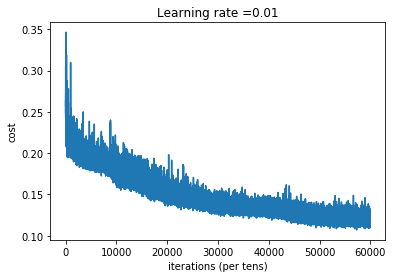

Parameters have been trained!
(1, 1459)


In [20]:
# model(X_train, Y_train, learning_rate = 0.0001,
# num_epochs = 1500, minibatch_size = 32, print_cost = True, layer_count = 3, hidder_neuron = [25, 12])

parameters = model(train_x, train_y, 
                   valid_x, valid_y,
                   test_x,
                   learning_rate=0.01, 
                   num_epochs=300000, 
                   minibatch_size = 128,
                   layer_count = 6, 
                   hidden_neuron = [100, 200, 400, 200, 100, 50])
